Creating a Teeth Segmentation object detection model using detetron2
===

Transform_json_for_detectron2
---

In [96]:
import os
import shutil

# 초기화할 디렉토리 경로
directory1 = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/dataset_ann"

# 디렉토리가 존재하는지 확인하고 있으면 삭제하고 다시 생성합니다.
if os.path.exists(directory1):
    shutil.rmtree(directory1)

os.makedirs(directory1)

Check json file format

In [97]:
import json

# replace with the path of one of your json files
json_path = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/ann/1.jpg.json"

with open(json_path, 'r') as file:
    data = json.load(file)

print(json.dumps(data, indent=4))

{
    "description": "",
    "tags": [],
    "size": {
        "height": 1024,
        "width": 2041
    },
    "objects": [
        {
            "id": 1166088923,
            "classId": 11382893,
            "description": "",
            "geometryType": "polygon",
            "labelerLogin": "GhazalehHITL",
            "createdAt": "2023-01-24T09:03:34.164Z",
            "updatedAt": "2023-01-24T09:03:34.164Z",
            "tags": [],
            "classTitle": "8",
            "points": {
                "exterior": [
                    [
                        963,
                        587
                    ],
                    [
                        964,
                        569
                    ],
                    [
                        968,
                        546
                    ],
                    [
                        971,
                        524
                    ],
                    [
                        974,
              

key = 'classTitle' 추출하기

In [86]:
import os
import json

def get_key_value(json_str, key):
    data = json.loads(json_str)
    values = [obj[key] for obj in data['objects']]
    return values

def get_all_key_values(directory, key):
    all_values = []

    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            with open(os.path.join(directory, filename), 'r') as file:
                json_str = file.read()
                values = get_key_value(json_str, key)
                all_values.extend(values)

    # Remove duplicates by converting the list to a set, then convert it back to a list
    all_values = list(set(all_values))
    # Sort the list in ascending order
    all_values = sorted(all_values)
    return all_values

# Test the function
directory_path = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/ann"
key = 'classTitle'
key_classTitle = get_all_key_values(directory_path, key)
print(key_classTitle)


['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '4', '5', '6', '7', '8', '9']


transform json format 1

In [66]:
import os
import json
import glob

def get_bbox(points):
    x_coordinates = [point[0] for point in points]
    y_coordinates = [point[1] for point in points]
    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]

def transform_to_coco_format(json_files):
    coco_format_json = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    annotation_id = 1
    category_id_set = set()

    for image_id, json_file in enumerate(json_files, start=1):
        with open(json_file, 'r') as file:
            data = json.load(file)

        image_info = {
            "id": image_id,
            "file_name": os.path.basename(json_file).replace(".json", ''),
            "width": data["size"]["width"],
            "height": data["size"]["height"]
        }

        coco_format_json["images"].append(image_info)

        for obj in data["objects"]:
            category_id = int(obj["classTitle"])
            category_id_set.add(category_id)

            segmentation = []  
            if 'points' in obj:
                for interior in obj['points']['interior']:
                    segmentation.extend(interior)
                for exterior in obj['points']['exterior']:
                    segmentation.extend(exterior)

            annotation_info = {
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,
                "segmentation": [segmentation], 
                "bbox": get_bbox(obj["points"]["exterior"]),
                "area": 0,  # You may calculate the actual area if necessary
                "iscrowd": 0
            }

            coco_format_json["annotations"].append(annotation_info)
            annotation_id += 1

    for category_id in category_id_set:
        category_info = {
            "id": category_id,
            "name": str(category_id)
        }
        coco_format_json["categories"].append(category_info)
        
    return coco_format_json

# Specify your directories
json_dir = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/ann"
output_file = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/dataset_ann/coco_format.json"

# Get all the JSON files in the input directory
json_files = glob.glob(os.path.join(json_dir, "*.json"))

# Transform JSON files to COCO format
coco_format_json = transform_to_coco_format(json_files)

# Save the COCO format data to the output directory
with open(output_file, "w") as f:
    json.dump(coco_format_json, f, indent=4)

print(f"COCO format JSON saved: {output_file}")


COCO format JSON saved: ./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/dataset_ann/coco_format.json


transform json format 2  
exterior[0]를 x로  exterior[1]를 y로  
현재 이걸로 모델 돌리는 중

In [98]:
import os
import json
import glob
import itertools

def get_bbox(points):
    x_coordinates = [point[0] for point in points]
    y_coordinates = [point[1] for point in points]
    min_x = min(x_coordinates)
    min_y = min(y_coordinates)
    width = max(x_coordinates) - min_x
    height = max(y_coordinates) - min_y
    return [min_x, min_y, width, height]

def transform_to_coco_format(json_files):
    coco_format_json = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    annotation_id = 1
    category_id_set = set()

    for image_id, json_file in enumerate(json_files, start=1):
        with open(json_file, 'r') as file:
            data = json.load(file)

        image_info = {
            "id": image_id,
            "file_name": os.path.basename(json_file).replace(".json", ''),
            "width": data["size"]["width"],
            "height": data["size"]["height"]
        }

        coco_format_json["images"].append(image_info)

        for obj in data["objects"]:
            category_id = int(obj["classTitle"])
            category_id_set.add(category_id)

            segmentation = []
            if 'points' in obj:
                for point_set in [obj['points']['interior'], obj['points']['exterior']]:
                    for point in point_set:
                        segmentation.extend(point)

            annotation_info = {
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,
                "segmentation": [segmentation],  # Wrap 'segmentation' in a list
                "bbox": get_bbox(obj["points"]["exterior"]),
                "area": 0,  # You may calculate the actual area if necessary
                "iscrowd": 0
            }

            coco_format_json["annotations"].append(annotation_info)
            annotation_id += 1

    for category_id in category_id_set:
        category_info = {
            "id": category_id,
            "name": str(category_id)
        }
        coco_format_json["categories"].append(category_info)
        
    return coco_format_json

# Specify your directories
json_dir = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/ann"
output_file = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/dataset_ann/coco_format.json"

# Get all the JSON files in the input directory
json_files = glob.glob(os.path.join(json_dir, "*.json"))

# Transform JSON files to COCO format
coco_format_json = transform_to_coco_format(json_files)

# Save the COCO format data to the output directory
with open(output_file, "w") as f:
    json.dump(coco_format_json, f, indent=4)

print(f"COCO format JSON saved: {output_file}")


COCO format JSON saved: ./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/dataset_ann/coco_format.json


In [89]:
# Get the first JSON file in the list
json_file = json_files[0]

# Load the JSON file
with open(json_file, 'r') as file:
    data = json.load(file)

# Print the 'points' value for each object in the JSON file
for obj in data["objects"]:
    print(f"Exterior points: {obj['points']['exterior']}")
    print(f"Interior points: {obj['points']['interior']}")

Exterior points: [[491, 447], [493, 432], [502, 407], [516, 384], [518, 359], [516, 337], [516, 321], [523, 297], [531, 279], [547, 264], [566, 260], [573, 288], [577, 310], [578, 327], [584, 341], [582, 359], [582, 376], [584, 386], [590, 402], [596, 419], [598, 435], [600, 445], [594, 459], [586, 469], [580, 479], [570, 482], [555, 481], [542, 478], [531, 475], [521, 470], [510, 466], [504, 457]]
Interior points: []
Exterior points: [[670, 525], [668, 510], [669, 492], [671, 474], [673, 457], [676, 440], [666, 428], [656, 410], [652, 397], [650, 373], [658, 359], [676, 360], [681, 373], [690, 395], [703, 406], [708, 391], [707, 372], [706, 360], [715, 343], [728, 344], [739, 365], [748, 381], [750, 404], [756, 425], [759, 440], [771, 461], [772, 477], [774, 492], [777, 503], [776, 517], [776, 528], [773, 540], [760, 548], [743, 555], [729, 553], [718, 546], [700, 543], [688, 545], [677, 539]]
Interior points: []
Exterior points: [[770, 557], [764, 545], [767, 520], [769, 496], [770, 

split_coco_dataset

In [99]:
import random
import json

def split_coco_dataset(coco_dataset, train_percentage):
    # Extract image ids and shuffle them
    image_ids = [image["id"] for image in coco_dataset["images"]]
    random.shuffle(image_ids)

    # Split image ids into training and test sets
    num_train = int(len(image_ids) * train_percentage)
    train_ids = set(image_ids[:num_train])
    test_ids = set(image_ids[num_train:])

    # Initialize the datasets
    train_dataset = {
        "images": [],
        "annotations": [],
        "categories": coco_dataset["categories"]
    }

    test_dataset = {
        "images": [],
        "annotations": [],
        "categories": coco_dataset["categories"]
    }

    # Populate the datasets
    for image in coco_dataset["images"]:
        if image["id"] in train_ids:
            train_dataset["images"].append(image)
        else:
            test_dataset["images"].append(image)

    for annotation in coco_dataset["annotations"]:
        if annotation["image_id"] in train_ids:
            train_dataset["annotations"].append(annotation)
        else:
            test_dataset["annotations"].append(annotation)
    
    return train_dataset, test_dataset

# Specify the location of your COCO dataset
coco_dataset_location = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/dataset_ann/coco_format.json"

# Load the COCO dataset
with open(coco_dataset_location, "r") as f:
    coco_dataset = json.load(f)

# Split the COCO dataset into training and testing datasets
train_percentage = 0.8  # Use 80% of the images for training
train_dataset, test_dataset = split_coco_dataset(coco_dataset, train_percentage)

# Specify the locations where you want to save your datasets
train_dataset_location = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/dataset_ann/train_dataset.json"
test_dataset_location = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/dataset_ann/test_dataset.json"

# Save the training dataset
with open(train_dataset_location, "w") as f:
    json.dump(train_dataset, f, indent=4)

# Save the testing dataset
with open(test_dataset_location, "w") as f:
    json.dump(test_dataset, f, indent=4)


Detectron2 model setting
---

In [101]:
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

# Assuming the data is in COCO format and the path to the json file and images are known
json_file = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/dataset_ann/train_dataset.json"
image_root = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/img"

dataset_name = "teeth_train"
# Remove existing registration if it exists
if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)
    MetadataCatalog.remove(dataset_name)

register_coco_instances(dataset_name, {}, json_file, image_root)

json_file_val = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/dataset_ann/test_dataset.json"
image_root_val = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/img"

dataset_name_val = "teeth_test"
# Remove existing registration if it exists
if dataset_name_val in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name_val)
    MetadataCatalog.remove(dataset_name_val)

register_coco_instances(dataset_name_val, {}, json_file_val, image_root_val)


train dataset visualization

[07/15 00:29:40 d2.data.datasets.coco]: Loaded 478 images in COCO format from ./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/dataset_ann/train_dataset.json
WARNING [07/15 00:29:40 d2.data.datasets.coco]: Filtered out 1 instances without valid segmentation. There might be issues in your dataset generation process.  Please check https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html carefully


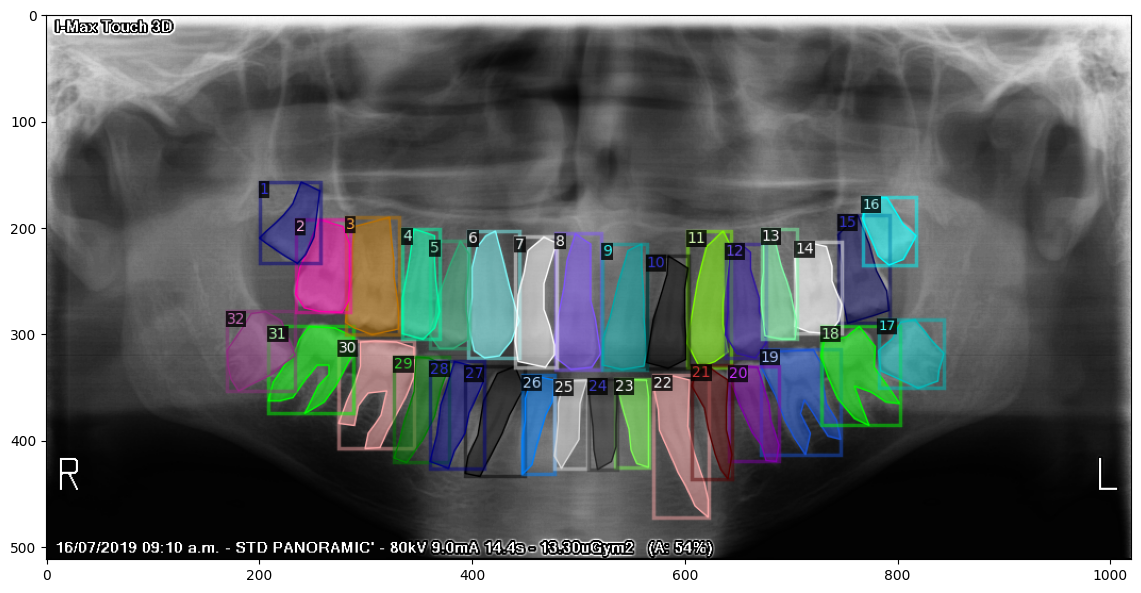

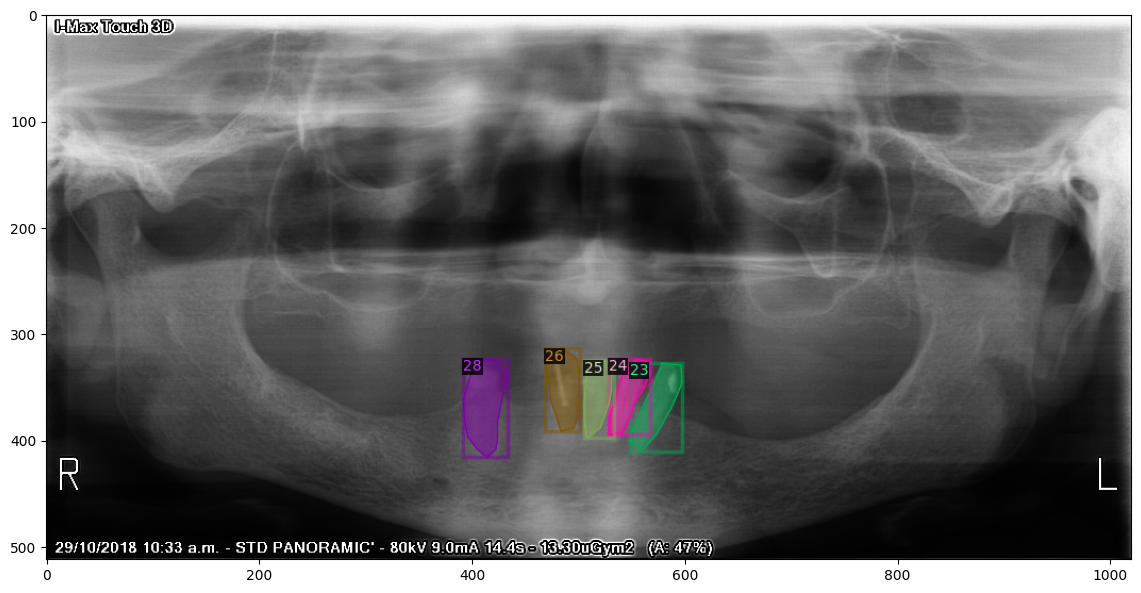

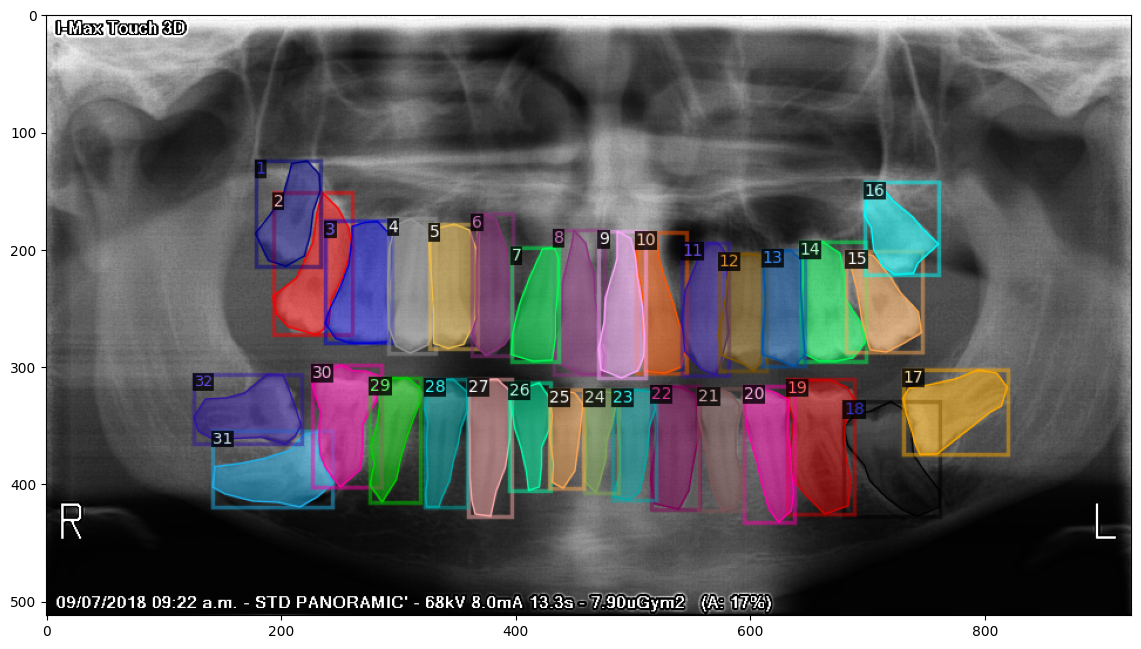

In [102]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Get the metadata of the training dataset
metadata = MetadataCatalog.get("teeth_train")

dataset_dicts = DatasetCatalog.get("teeth_train")
for d in random.sample(dataset_dicts, 3):  # randomly select 3 instances from the dataset
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(14, 10))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()


Detectron2 model training
---

Check the location of the detectron2 model

In [62]:
import glob

file_path = None

# Search for the file in the file system
for file in glob.glob("**/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", recursive=True):
    file_path = file
    break  # Stop searching after finding the first occurrence

if file_path is not None:
    directory = file_path.rsplit("/", 1)[0]
    print("Directory containing 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml':", directory)
else:
    print("'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml' not found.")


Directory containing 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml': configs/COCO-Detection


In [63]:
import glob

file_path = None

# Search for the file in the file system
for file in glob.glob("**/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml", recursive=True):
    file_path = file
    break  # Stop searching after finding the first occurrence

if file_path is not None:
    directory = file_path.rsplit("/", 1)[0]
    print("Directory containing 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml':", directory)
else:
    print("'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml' not found.")


Directory containing 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml': configs/COCO-Detection


Using "CPU"
---

Object detection

HERE!!!!!!!!!!!!!!!!!!!
COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml
configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml
[07/13 20:53:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2),

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (124, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (124,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bi

[07/13 20:53:05 d2.engine.train_loop]: Starting training from iteration 0
[07/13 20:54:30 d2.utils.events]:  eta: 3:31:35  iter: 19  total_loss: 4.808  loss_cls: 3.524  loss_box_reg: 0.8043  loss_rpn_cls: 0.3017  loss_rpn_loc: 0.1787    time: 4.2055  last_time: 4.4311  data_time: 0.0084  last_data_time: 0.0028   lr: 4.9953e-06  
[07/13 20:55:55 d2.utils.events]:  eta: 3:31:18  iter: 39  total_loss: 4.604  loss_cls: 3.412  loss_box_reg: 0.7961  loss_rpn_cls: 0.2227  loss_rpn_loc: 0.1803    time: 4.2262  last_time: 3.7773  data_time: 0.0024  last_data_time: 0.0025   lr: 9.9902e-06  
[07/13 20:57:13 d2.utils.events]:  eta: 3:19:36  iter: 59  total_loss: 4.343  loss_cls: 3.185  loss_box_reg: 0.8408  loss_rpn_cls: 0.1464  loss_rpn_loc: 0.1748    time: 4.1099  last_time: 3.6941  data_time: 0.0025  last_data_time: 0.0023   lr: 1.4985e-05  
[07/13 20:58:32 d2.utils.events]:  eta: 3:16:59  iter: 79  total_loss: 3.895  loss_cls: 2.813  loss_box_reg: 0.8418  loss_rpn_cls: 0.07286  loss_rpn_loc: 0

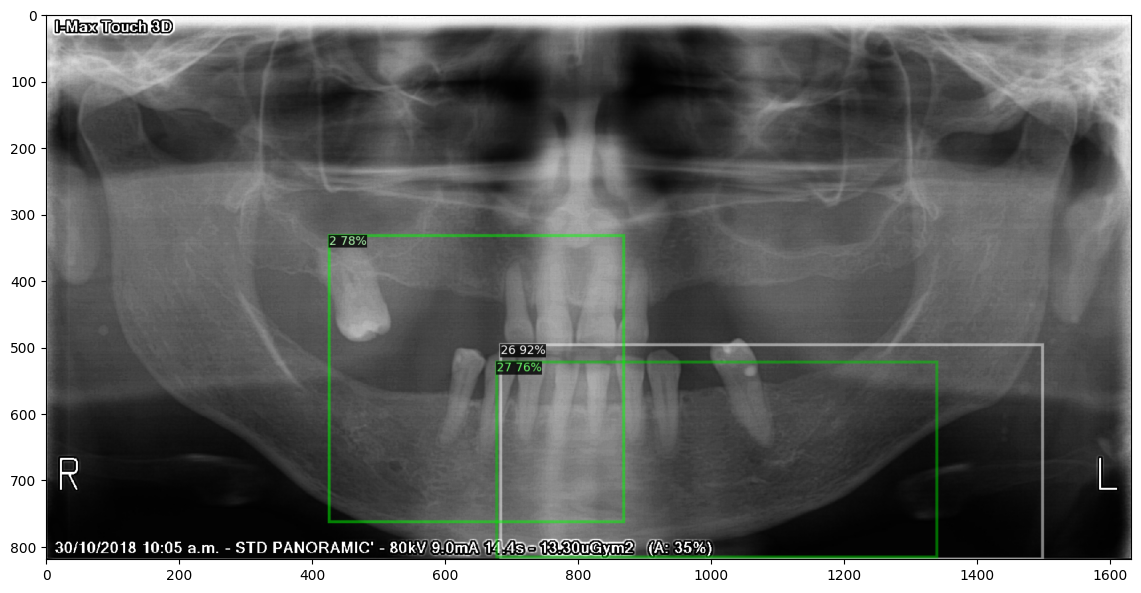

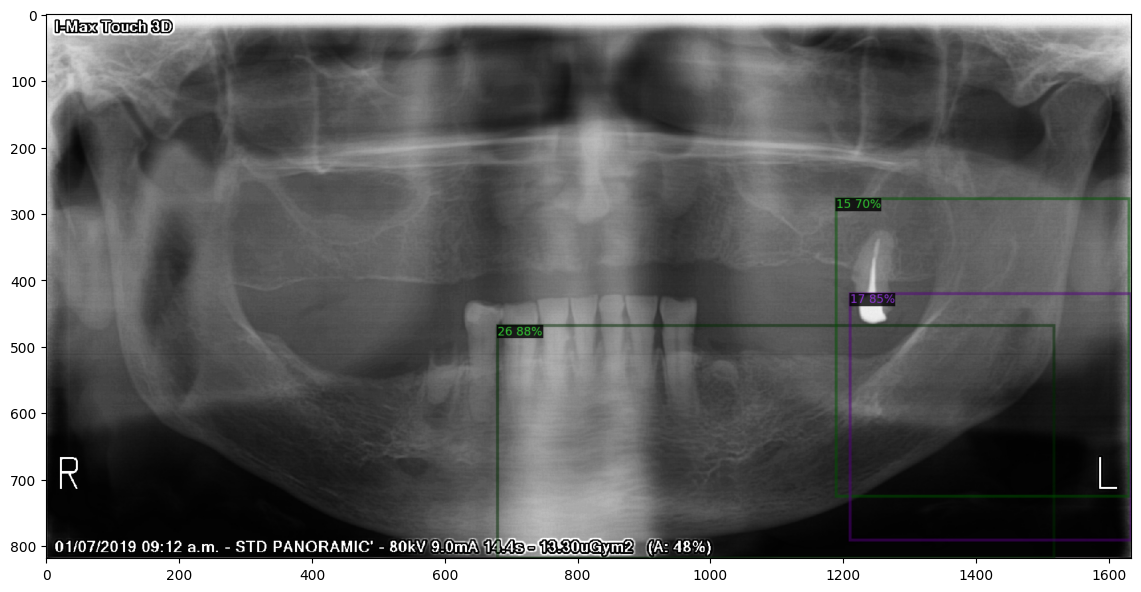

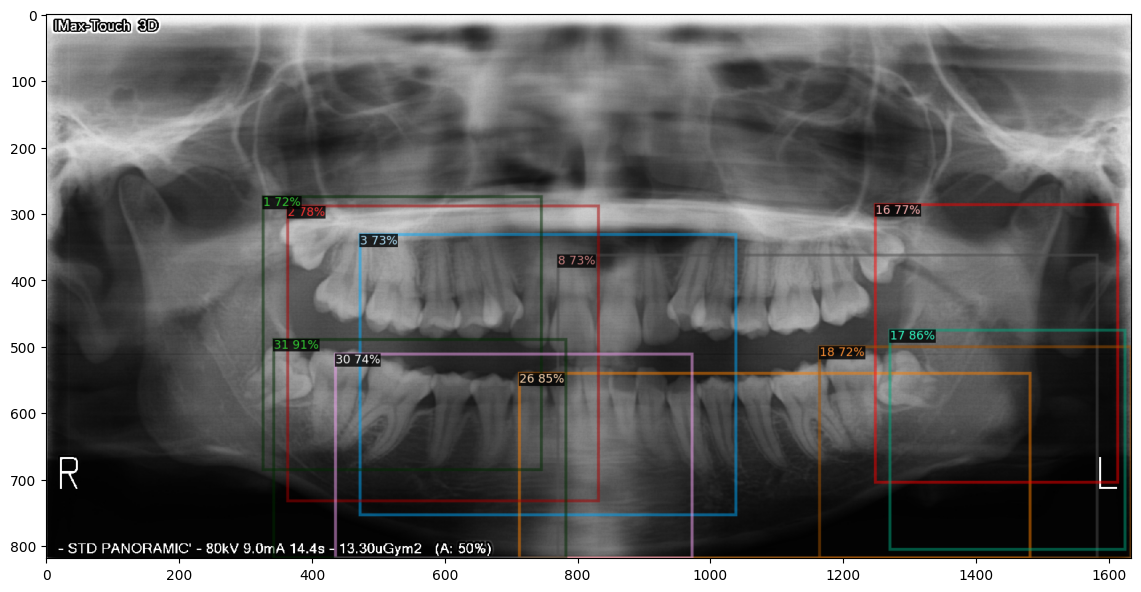

In [7]:
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2 import model_zoo

import cv2
import matplotlib.pyplot as plt
import os
import random

# Step 1: Configure the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("teeth_train",)  # Use the dataset name for training
cfg.DATASETS.TEST = ("teeth_test",)  # Use the dataset name for testing
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Use pre-trained weights

# Step 2: Set up the training parameters
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000  # Train for this many iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 31  # Set the number of classes based on your dataset
cfg.MODEL.DEVICE = 'cpu'  # Use CPU instead of GPU

# Step 3: Train the model
cfg.OUTPUT_DIR = './Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Step 4: Test the model
evaluator = COCOEvaluator("teeth_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "teeth_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

# Step 5: Visualize the predictions
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Use the final weights from training
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Set the testing threshold
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("teeth_test")

for d in random.sample(DatasetCatalog.get("teeth_test"), 3):  # Randomly select data
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=test_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()


Segmentation Analysis 

HERE!!!!!!!!!!!!!!!!!!!
COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml
configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml
[07/14 18:40:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (124, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (124,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (31, 256, 1

[07/14 18:40:44 d2.engine.train_loop]: Starting training from iteration 0
[07/14 18:42:16 d2.utils.events]:  eta: 3:45:40  iter: 19  total_loss: 5.585  loss_cls: 3.513  loss_box_reg: 0.8738  loss_mask: 0.6939  loss_rpn_cls: 0.3319  loss_rpn_loc: 0.215    time: 4.5461  last_time: 4.4883  data_time: 0.0163  last_data_time: 0.0026   lr: 4.9953e-06  
[07/14 18:43:48 d2.utils.events]:  eta: 3:43:59  iter: 39  total_loss: 5.35  loss_cls: 3.37  loss_box_reg: 0.8284  loss_mask: 0.6932  loss_rpn_cls: 0.2488  loss_rpn_loc: 0.2073    time: 4.5625  last_time: 4.6135  data_time: 0.0026  last_data_time: 0.0027   lr: 9.9902e-06  
[07/14 18:45:20 d2.utils.events]:  eta: 3:43:20  iter: 59  total_loss: 4.901  loss_cls: 3.072  loss_box_reg: 0.8591  loss_mask: 0.6917  loss_rpn_cls: 0.1299  loss_rpn_loc: 0.1696    time: 4.5828  last_time: 4.7599  data_time: 0.0026  last_data_time: 0.0028   lr: 1.4985e-05  
[07/14 18:46:50 d2.utils.events]:  eta: 3:41:00  iter: 79  total_loss: 4.418  loss_cls: 2.587  loss_b

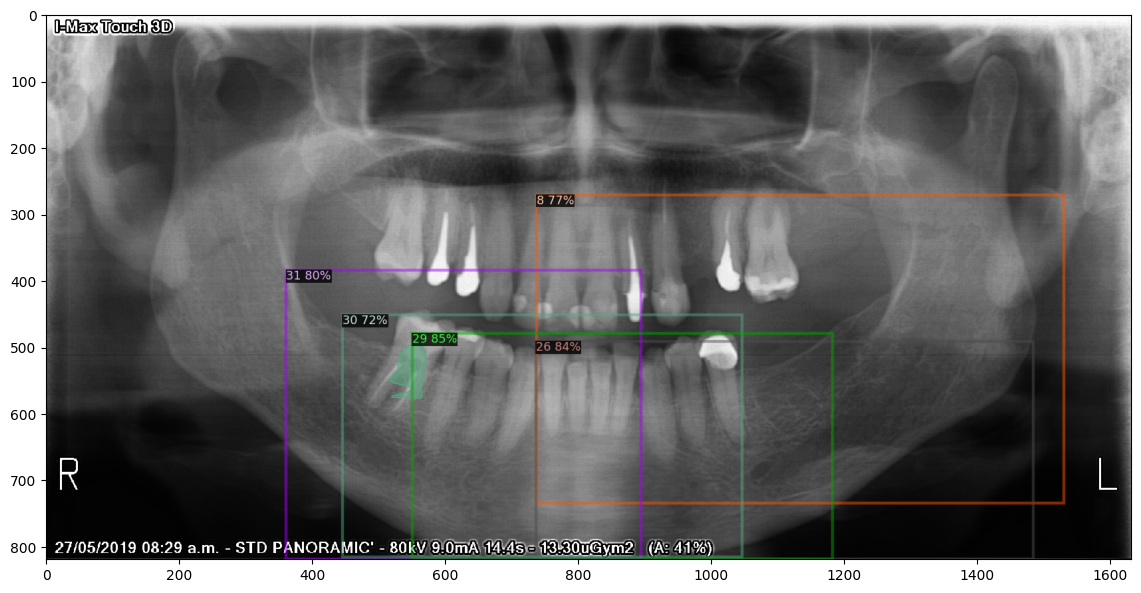

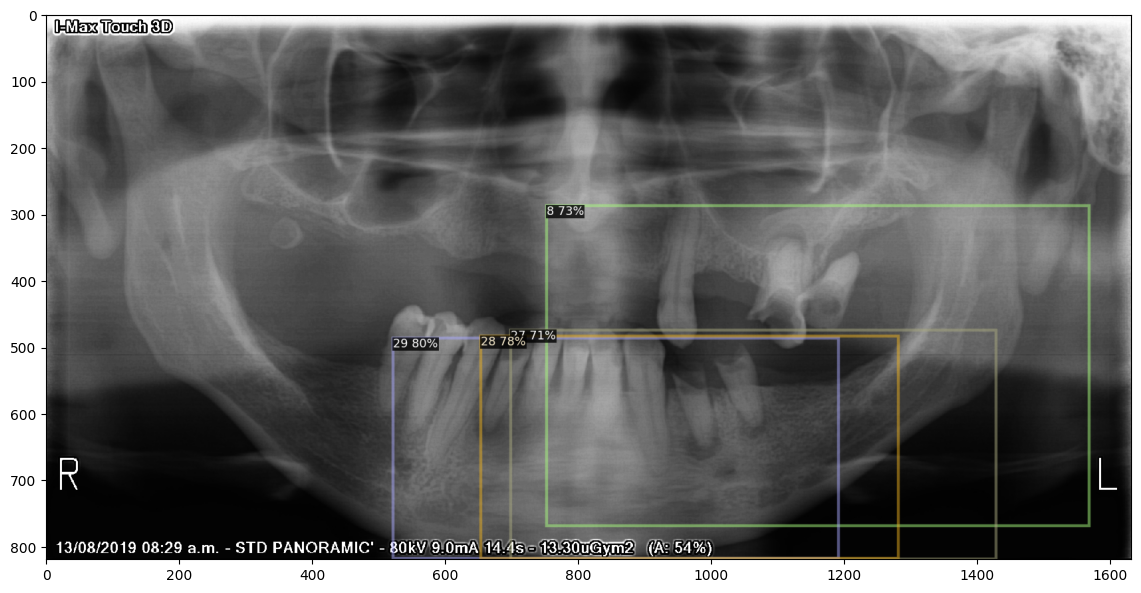

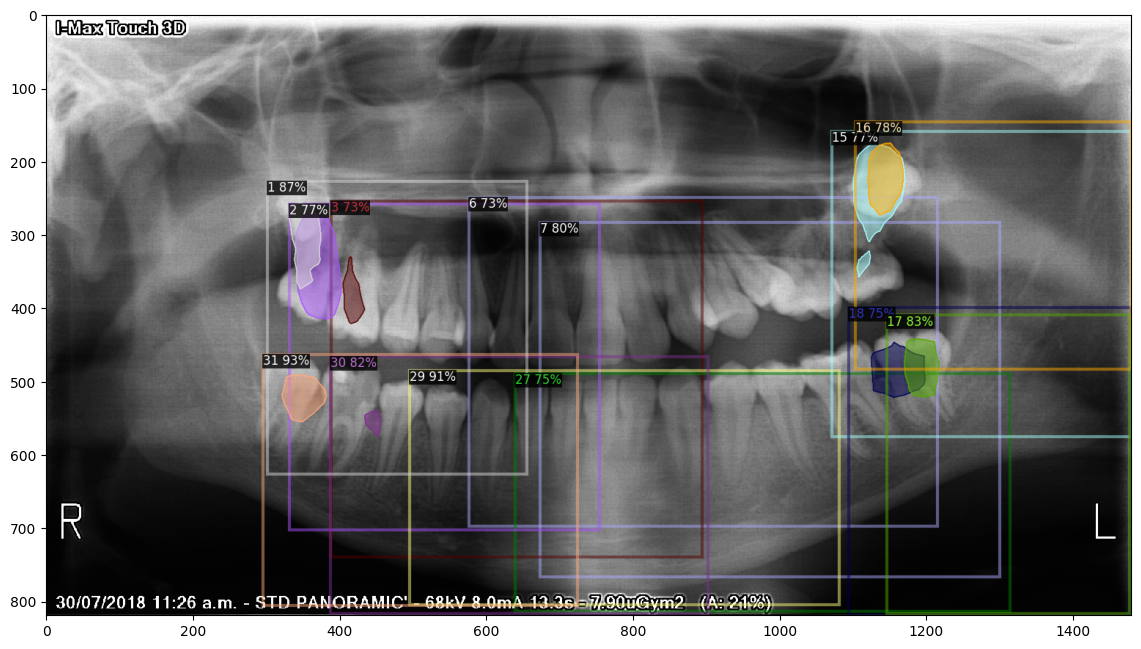

In [69]:
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2 import model_zoo

import cv2
import matplotlib.pyplot as plt
import os
import random

# Step 1: Configure the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")) # use Mask R-CNN model with ResNet-101
cfg.DATASETS.TRAIN = ("teeth_train",)  # Use the dataset name for training
cfg.DATASETS.TEST = ("teeth_test",)  # Use the dataset name for testing
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Use pre-trained weights

# Step 2: Set up the training parameters
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000  # Train for this many iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 31  # Set the number of classes based on your dataset
cfg.MODEL.DEVICE = 'cpu'  # Use CPU instead of GPU

# Step 3: Train the model
cfg.OUTPUT_DIR = './Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Step 4: Test the model
evaluator = COCOEvaluator("teeth_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "teeth_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

# Step 5: Visualize the predictions
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Use the final weights from training
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Set the testing threshold
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("teeth_test")

for d in random.sample(DatasetCatalog.get("teeth_test"), 3):  # Randomly select data
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=test_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()


HERE!!!!!!!!!!!!!!!!!!!
COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml
configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml
[07/15 00:30:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (124, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (124,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (31, 256, 1

[07/15 00:30:34 d2.engine.train_loop]: Starting training from iteration 0
[07/15 00:32:08 d2.utils.events]:  eta: 3:45:06  iter: 19  total_loss: 6.589  loss_cls: 3.58  loss_box_reg: 0.7302  loss_mask: 0.6929  loss_rpn_cls: 1.437  loss_rpn_loc: 0.1761    time: 4.5936  last_time: 4.5046  data_time: 0.0159  last_data_time: 0.0030   lr: 4.9953e-06  
[07/15 00:33:40 d2.utils.events]:  eta: 3:43:20  iter: 39  total_loss: 5.335  loss_cls: 3.449  loss_box_reg: 0.7895  loss_mask: 0.693  loss_rpn_cls: 0.3002  loss_rpn_loc: 0.1547    time: 4.5939  last_time: 5.0772  data_time: 0.0030  last_data_time: 0.0030   lr: 9.9902e-06  
[07/15 00:35:11 d2.utils.events]:  eta: 3:41:45  iter: 59  total_loss: 4.886  loss_cls: 3.166  loss_box_reg: 0.8173  loss_mask: 0.6926  loss_rpn_cls: 0.08513  loss_rpn_loc: 0.1465    time: 4.5771  last_time: 4.5036  data_time: 0.0029  last_data_time: 0.0030   lr: 1.4985e-05  
[07/15 00:36:42 d2.utils.events]:  eta: 3:40:33  iter: 79  total_loss: 4.509  loss_cls: 2.782  loss_

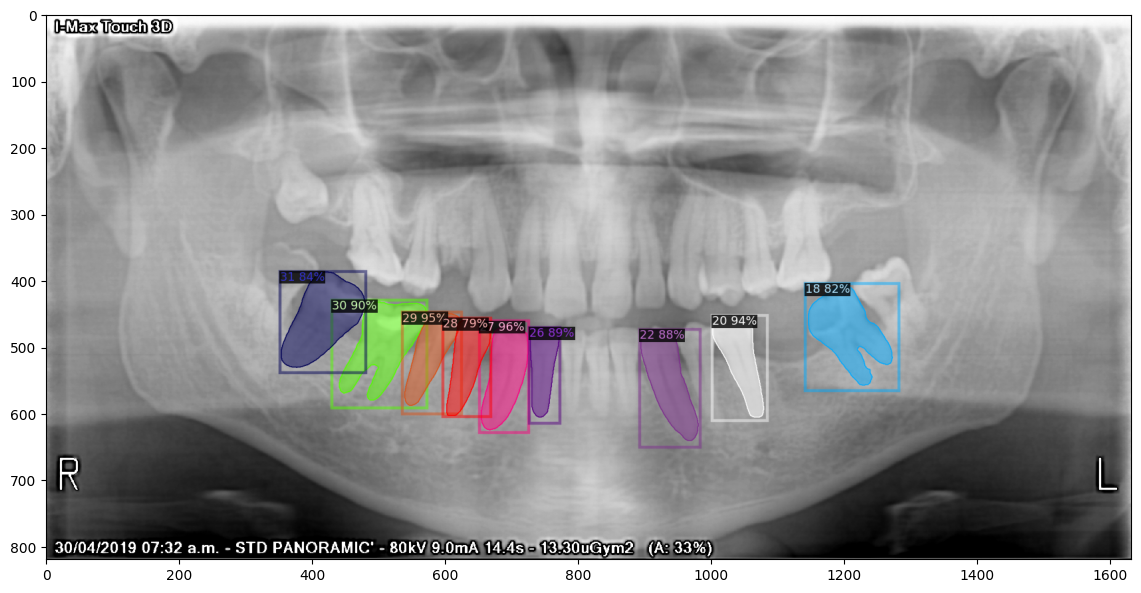

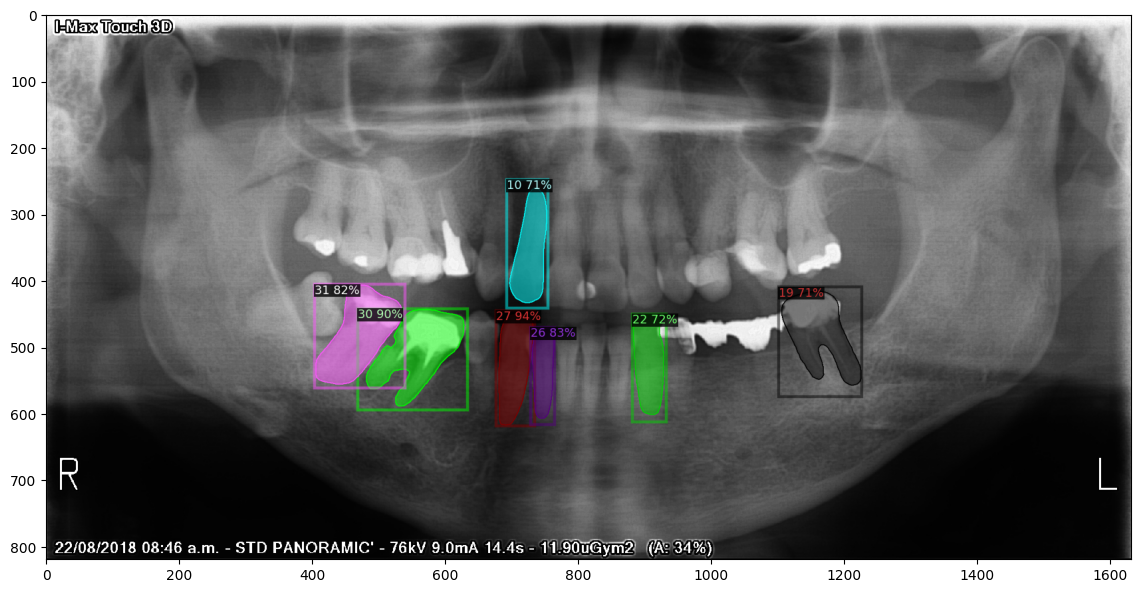

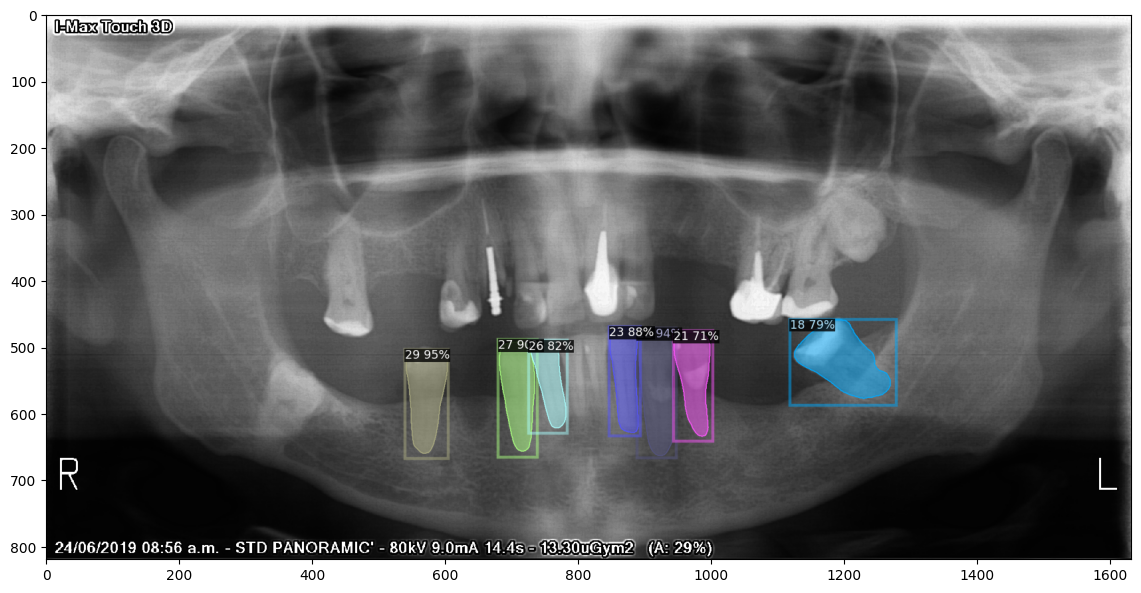

In [103]:
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2 import model_zoo

import cv2
import matplotlib.pyplot as plt
import os
import random

# Step 1: Configure the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")) # use Mask R-CNN model with ResNet-101
cfg.DATASETS.TRAIN = ("teeth_train",)  # Use the dataset name for training
cfg.DATASETS.TEST = ("teeth_test",)  # Use the dataset name for testing
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Use pre-trained weights

# Step 2: Set up the training parameters
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000  # Train for this many iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 31  # Set the number of classes based on your dataset
cfg.MODEL.DEVICE = 'cpu'  

# Step 3: Train the model with TensorBoard support
cfg.OUTPUT_DIR = './Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Step 4: Test the model
evaluator = COCOEvaluator("teeth_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "teeth_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

# Step 5: Visualize the predictions
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Use the final weights from training
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Set the testing threshold
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("teeth_test")

for d in random.sample(DatasetCatalog.get("teeth_test"), 3):  # Randomly select data
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=test_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()


In [104]:
%load_ext tensorboard
%tensorboard --logdir ./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

Segmentation Analysis by Modifying Hyperparameters 1
  
cfg.SOLVER.IMS_PER_BATCH = 4  
cfg.SOLVER.BASE_LR = 0.0001  
cfg.SOLVER.MAX_ITER = 5000  

HERE!!!!!!!!!!!!!!!!!!!
COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml
configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml
[07/15 04:25:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (124, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (124,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (31, 256, 1

[07/15 04:25:40 d2.engine.train_loop]: Starting training from iteration 0
[07/15 04:28:58 d2.utils.events]:  eta: 13:28:57  iter: 19  total_loss: 6.892  loss_cls: 3.477  loss_box_reg: 0.7245  loss_mask: 0.6933  loss_rpn_cls: 1.853  loss_rpn_loc: 0.1928    time: 9.7973  last_time: 10.3155  data_time: 0.0227  last_data_time: 0.0056   lr: 1.9981e-06  
[07/15 04:32:18 d2.utils.events]:  eta: 13:25:57  iter: 39  total_loss: 6.095  loss_cls: 3.424  loss_box_reg: 0.7262  loss_mask: 0.6932  loss_rpn_cls: 1.095  loss_rpn_loc: 0.18    time: 9.9123  last_time: 11.2225  data_time: 0.0058  last_data_time: 0.0053   lr: 3.9961e-06  
[07/15 04:35:33 d2.utils.events]:  eta: 13:22:40  iter: 59  total_loss: 5.195  loss_cls: 3.336  loss_box_reg: 0.8092  loss_mask: 0.6931  loss_rpn_cls: 0.234  loss_rpn_loc: 0.1427    time: 9.8589  last_time: 9.6708  data_time: 0.0059  last_data_time: 0.0063   lr: 5.9941e-06  
[07/15 04:38:52 d2.utils.events]:  eta: 13:18:53  iter: 79  total_loss: 4.958  loss_cls: 3.19  los

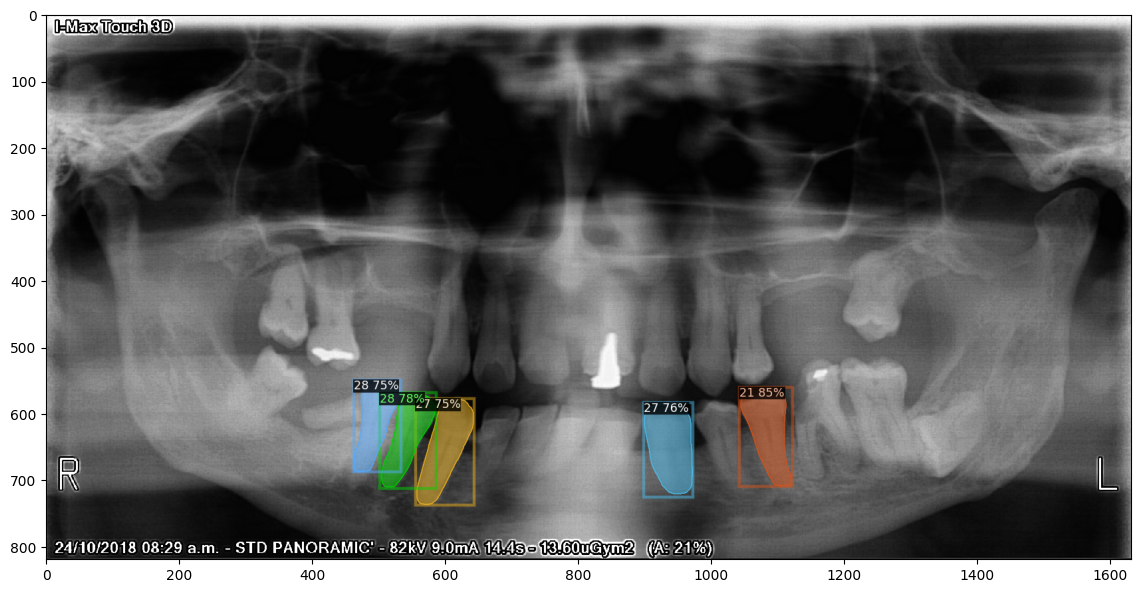

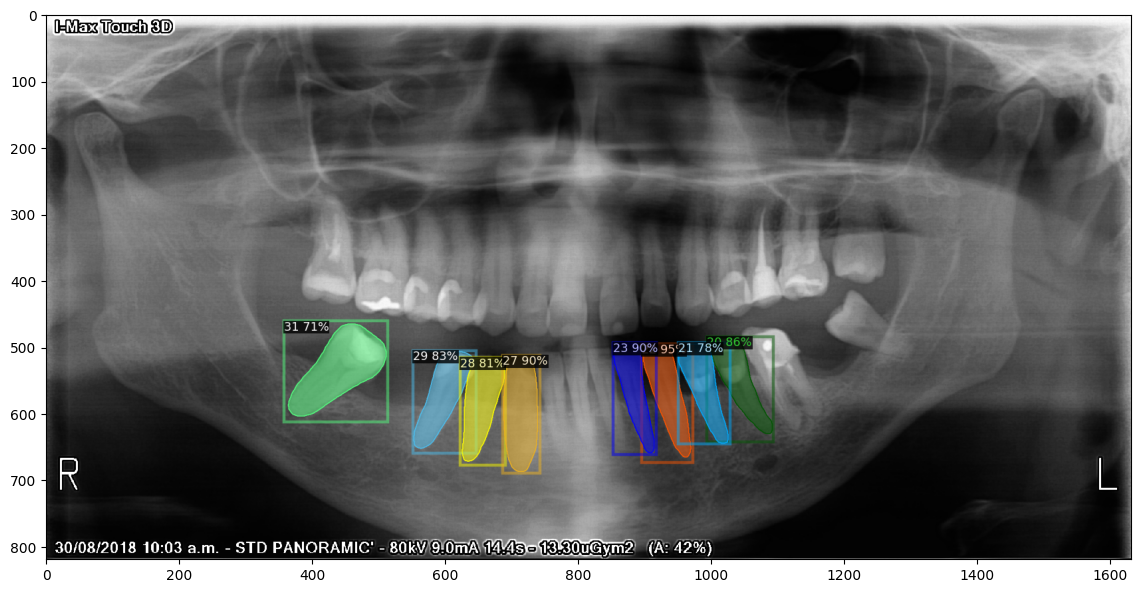

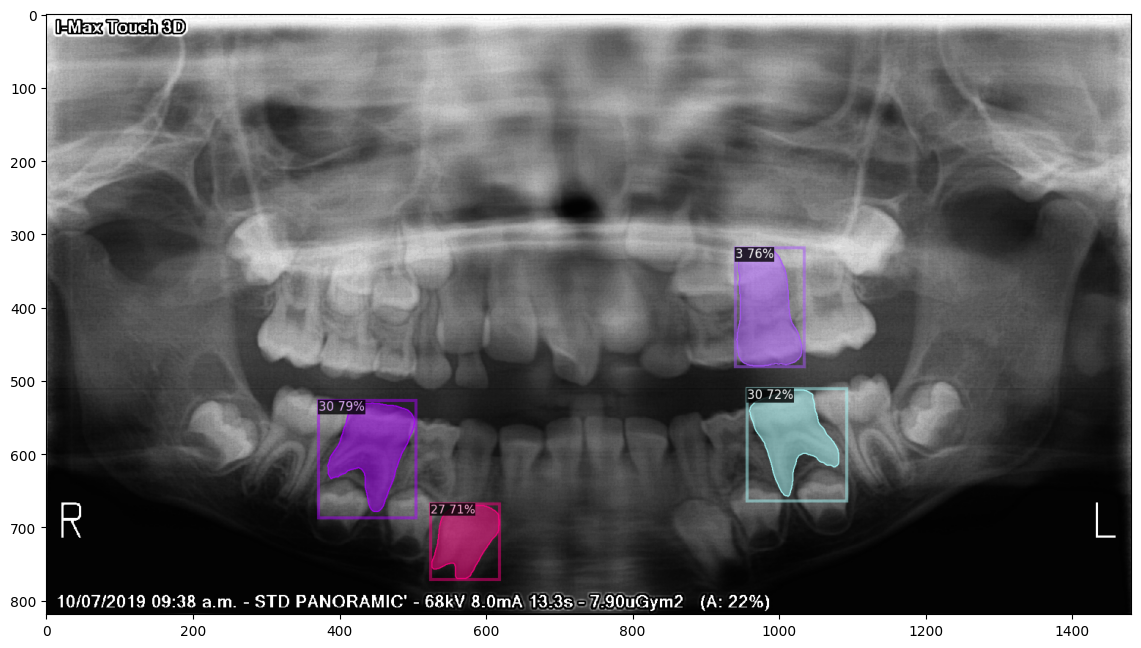

In [105]:
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2 import model_zoo

import cv2
import matplotlib.pyplot as plt
import os
import random

# Step 1: Configure the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")) # use Mask R-CNN model with ResNet-101
cfg.DATASETS.TRAIN = ("teeth_train",)  # Use the dataset name for training
cfg.DATASETS.TEST = ("teeth_test",)  # Use the dataset name for testing
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Use pre-trained weights

# Step 2: Set up the training parameters
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 5000  # Train for this many iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 31  # Set the number of classes based on your dataset
cfg.MODEL.DEVICE = 'cpu'  

# Step 3: Train the model with TensorBoard support
cfg.OUTPUT_DIR = './Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Step 4: Test the model
evaluator = COCOEvaluator("teeth_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "teeth_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

# Step 5: Visualize the predictions
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Use the final weights from training
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Set the testing threshold
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("teeth_test")

for d in random.sample(DatasetCatalog.get("teeth_test"), 3):  # Randomly select data
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=test_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()


In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2


Using GPU
---

In [ ]:
# Step 1: Configure the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")) # use Mask R-CNN model with ResNet-101
cfg.DATASETS.TRAIN = ("teeth_train",)  # Use the dataset name for training
cfg.DATASETS.TEST = ("teeth_test",)  # Use the dataset name for testing
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Use pre-trained weights

# Step 2: Set up the training parameters
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000  # Train for this many iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 31  # Set the number of classes based on your dataset

# Use GPU instead of CPU
cfg.MODEL.DEVICE = 'cuda' 

# Step 3: Train the model
cfg.OUTPUT_DIR = './Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Step 4: Test the model
evaluator = COCOEvaluator("teeth_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "teeth_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

# Step 5: Visualize the predictions
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Use the final weights from training
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Set the testing threshold
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("teeth_test")

for d in random.sample(DatasetCatalog.get("teeth_test"), 3):  # Randomly select data
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=test_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()
